# Определение выгодного тарифа для клиентов телеком компании

На основе данных о поведении клиентов необходимо построить модель классификации, способную подобрать для клиентов телеком компании наиболее подходящий тариф. Метрика accuracy должна быть не меньше 0.75.

* [1. Чтение файла и изучение данных](#first_bullet)
    * [Импорт библиотек](#second_bullet)
    * [Изучение данных](#third_bullet)
* [2. Разбиение данных на выборки](#fourth_bullet)
* [3. Исследование моделей](#fifth_bullet)
    * [Дерево принятия решений](#sixth_bullet)
    * [Случайный лес](#seventh_bullet)
    * [Логистическая регрессия](#eighth_bullet)
    * [Сравнение моделей](#ninth_bullet)
* [4. Проверка модели на тестовой выборке](#tenth_bullet)
* [5. Проверка модели на адекватность](#eleventh_bullet)
* [Вывод](#twelfth_bullet)

## 1. Чтение файла и изучение данных<a id="first_bullet"></a>

### Импорт библиотек<a id="second_bullet"></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
plt.style.use('seaborn')

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

<ipython-input-2-b2cfcd38eea6>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Изучение данных<a id="third_bullet"></a>

Прочитаем файл и сохраним данные в переменной *df*.

In [4]:
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Посмотрим общую информацию о датафрейме.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Датафрейм *df* содержит следующие столбцы:

- сalls — количество звонков
- minutes — суммарная длительность звонков в минутах
- messages — количество sms-сообщений
- mb_used — израсходованный интернет-трафик в Мб
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Датафрейм содержит 5 признаков и 3214 объекта, пропусков нету. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Поскольку признак *is_ultra* содержит объекты булев типа («Ультра» — 1, «Смарт» — 0), заменим тип данных для этого признака на логический или булев тип.

In [ ]:
df['is_ultra'] = df['is_ultra'].astype('bool')
df.dtypes

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra    bool   
dtype: object

Посмотрим, сколько и какую долю объектов каждого типа — «Ультра» и «Смарт» — содержит датафрейм. Визуализируем результат.

In [6]:
values = df['is_ultra'].value_counts()
values = values.to_frame().reset_index()
values.columns = ['Boolean', 'Count']
values['Percentage'] = df['is_ultra'].value_counts(normalize=True)
pd.DataFrame(values)

values['Tariff'] = values['Boolean'].apply(lambda x: 'Ультра' if x == True else 'Смарт')
values

,Boolean,Count,Percentage,Tariff
0,0,2229,0.693528,Смарт
1,1,985,0.306472,Ультра


In [13]:
fig = make_subplots(rows = 1, cols = 2,
                    specs = [[{"type": "bar"}, {"type": "pie"}]],
                    subplot_titles = ('К-во пользователей по тарифам',
                                    'Доля пользователей по тарифам'))

fig.add_trace(go.Bar(x = values['Tariff'], y = values['Count']), row = 1, col = 1)
fig.add_trace(go.Pie(values = values['Percentage'], labels = values['Tariff']), row = 1, col = 2)

fig.update_layout(height = 500, showlegend = False, title_text = "Пользователи в зависимости от выбранного тарифа")
fig.show()

Около 70% пользователей используют тариф «Смарт», а 30% — тариф «Ультра».

**Результат:** На этом этапе проекта открыли и изучили данные, провели замену типа данных для признака *is_ultra* и убедились, что данные не содержат пропуски.

## 2. Разбиение данных на выборки<a id="fourth_bullet"></a>

Так как спрятанной тестовой выборки у нас нету, разделим исходные данные на три выборки: обучающую, валидационную и тестовую.

Сначала методом *train_test_split* разделим исходные данные на обучающую (60%) и валидационную выборку (40%). После этого разделим валидационную выборку пополам — на валидационную и тестовую выборки. Таким образом каждая из этих 2-х выборок составит 20% из всех данных *df*.

In [14]:
df_train, df_valid = train_test_split(df, train_size=0.60, test_size=0.40, random_state=123)
df_valid, df_test = train_test_split(df_valid, train_size=0.50, test_size=0.50, random_state=123)

Проверка результата.

In [15]:
samples = {'Обучающая выборка' : df_train,
           'Валидационная выборка': df_valid,
           'Тестовая выборка': df_test}

for key, value in samples.items():
    print(key + ':', round(len(value) / len(df)*100), '%')

Обучающая выборка: 60 %
Валидационная выборка: 20 %
Тестовая выборка: 20 %


В каждой выборке выделим признаки *(features)* и целевой признак *(target)*. В данном случае целевым признаком является значения столбца *is_ultra*, а признаками — значение всех остальных столбцов датафрейма *df*.  

In [16]:
# обучающая выборка
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

# валидационная выборка
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

# тестовая выборка
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

**Результат:** На этом этапе проекта разбили исходные данные на обучающую, валидационную и тестовую выборки, и в каждой из них выделили признаки и целевой признак.

## 3. Исследование моделей<a id="fifth_bullet"></a>

Так как перед нами стоит задача бинарной классификации — проанализировать поведение клиентов и предложить пользователям новый тариф — на этом этапе рассмотрим следующие модели классификации:
- дерево принятия решений *(Decision Tree Classifier)*
- случайный лес *(Random Forest Classifier)*
- логистическая регрессия *(Logistic Regression)*.

### Дерево принятия решений<a id="sixth_bullet"></a>

Сначала проверим, какой результат дает данная модель без смены гиперпараметров, а потом, изменяя гиперпараметры, попробуем улучшить работу модели.

In [17]:
model_dtc = DecisionTreeClassifier(random_state=123)
model_dtc.fit(features_train, target_train)
predictions_valid = model_dtc.predict(features_valid)
accuracy_dtc = accuracy_score(target_valid, predictions_valid)

print('Result:', accuracy_dtc)

Result: 0.7465007776049767


Сохраним результат в переменной *results_from_box*, чтобы в итоге можно было сравнить, какая модель показала наилучший результат без настройки гиперпараметров.

In [18]:
results_from_box = []
results_from_box.append({'DecisionTreeClassifier': accuracy_dtc})
results_from_box

[{'DecisionTreeClassifier': 0.7465007776049767}]

Настроим гиперпараметр *max-depth* (глубина деревьев) и посмотрим, как это улучшит работу модели. Для этого в цикле переберем значения глубины деревьев в диапазоне от 1 до 11.

Результат сохраним в переменной *results_dtc*.

In [23]:
results_dtc = []

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    model.fit(features_train, target_train)

    predictions_valid = model.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)

    results_dtc.append({'Model name': 'DecisionTreeClassifier',
                    'Hyperparameters': {'random_state': 123, 'max_depth':depth},
                    'Accuracy score': accuracy_valid})

Выводим результат.

In [39]:
df_dtc = pd.DataFrame.from_dict(results_dtc)
df_dtc

,Model name,Hyperparameters,Accuracy score
0,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 1}",0.762053
1,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 2}",0.790047
2,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 3}",0.802488
3,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 4}",0.804044
4,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 5}",0.822706
5,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 6}",0.814930
6,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 7}",0.811820
7,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 8}",0.802488
8,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 9}",0.818040
9,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 10}",0.802488


Видим, что наилучший результат модель дает при глубине 5 (accuracy_score = ~0,82). Такое значение гиперпараметра *max_depth* позволит модели обучится, но в тоже время не позволит ей разрастись, что могло бы привести модель к переобучению.

Самый лучший результат сохраним в переменной *best_results*.

In [40]:
best_results = []
best_results.append(df_dtc.loc[4])

Для наглядности полученный результат можно визуализировать.  

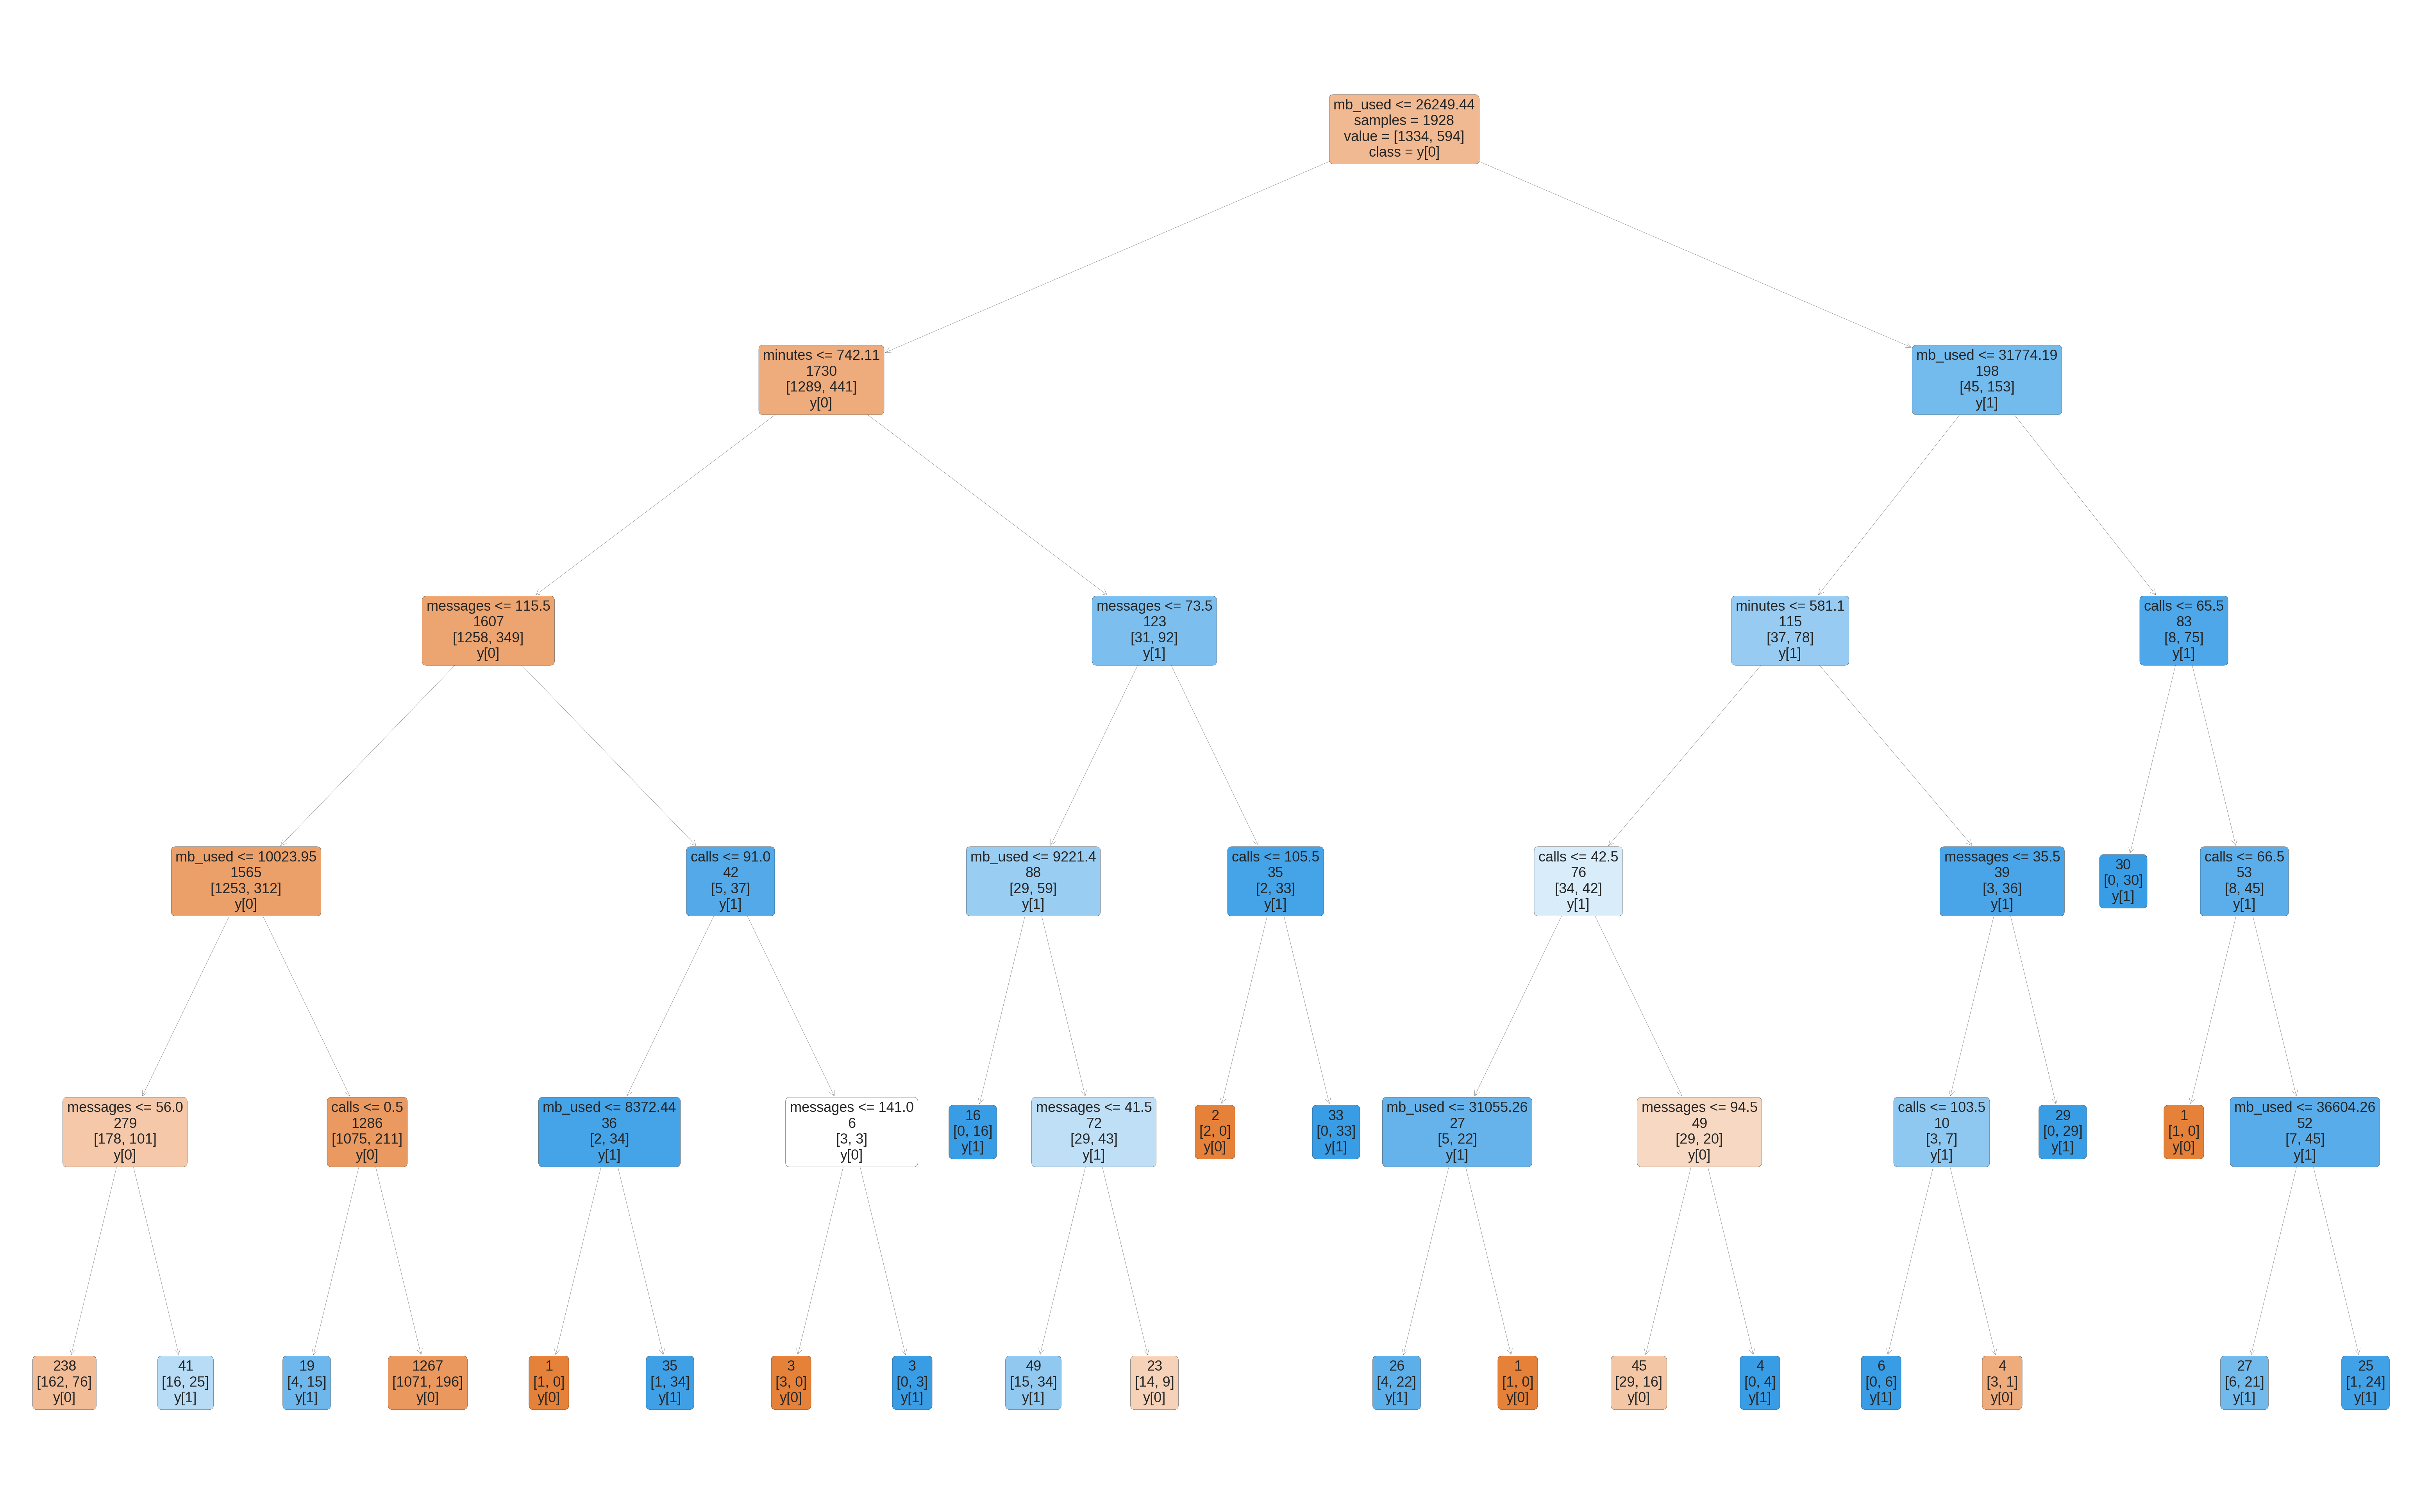

In [43]:
model_dtc = DecisionTreeClassifier(random_state=123, max_depth=5)
model_dtc.fit(features_train, target_train)

plt.figure(figsize=(80,50))

fig = plot_tree(model_dtc,
                feature_names=features_train.columns,
                precision = 2,
                filled = True,
                rounded = True,
                class_names = True,
                fontsize = 26,
                label = 'root',
                impurity=False)

Из визуализации видим, что все узлы содержат 4 части:
- *feature_names* — имя признака
- *samples* — количество образцов, которые прошли через этот узел (в абсолютных числах)
- *value* — отношение классов, прошедших через этот узел (в абсолютных числах). Видим, что самый верхний узел выделил 1334 образца из класса 0 и 594 образца из класса 1.
- *class* — показывает, к какому классу принадлежит большинства образцов, прошедших через узел.

Дальше исследуем модель *Случайный лес*.

### Случайный лес<a id="seventh_bullet"></a>

Проверим, как работает модель «из коробки», а результат сохраним в переменной *results_from_box*.

In [44]:
model_rfc = RandomForestClassifier(random_state=123)
model_rfc.fit(features_train, target_train)

predictions_rfc = model_rfc.predict(features_valid)
accuracy_rfc = accuracy_score(target_valid, predictions_rfc)

print('Result:', accuracy_rfc)

Result: 0.8180404354587869


In [45]:
results_from_box.append({'RandomForestClassifier': accuracy_rfc})
results_from_box

[{'DecisionTreeClassifier': 0.7465007776049767},
 {'RandomForestClassifier': 0.8180404354587869}]

Видим, что результат значительно лучше, чем показала модель *DecisionTreeClassifier*.

В цикле настроим гиперпараметры *n_estimators* и *max_depth*. Гиперпараметр *n_estimators* показывает количество деревьев в "лесу" (чем выше показатель, тем больше модель разрастается и медленнее обучается), а *max_depth* — глубину деревьев.

In [46]:
results_rfc = []

for depth in range(1,11):

    for estimator in range(10, 101, 10):

        model = RandomForestClassifier(random_state=123, n_estimators=estimator, max_depth=depth)
        model.fit(features_train, target_train)

        predictions_valid = model.predict(features_valid)
        accuracy_valid = accuracy_score(target_valid, predictions_valid)

        results_rfc.append({'Model name': 'RandomForestClassifier',
                            'Hyperparameters': {'random_state': 123,
                                                'n_estimators': estimator,
                                                'max_depth':depth},
                            'Accuracy score': accuracy_valid})

Все результаты сохранены в переменной *results_rfc*. Выведем на экран ту комбинацию гиперпараметров, которая дает самый высокий показатель *аccuracy_score*.

In [50]:
df_rfc = pd.DataFrame.from_dict(results_rfc)
df_rfc[df_rfc['Accuracy score']==df_rfc['Accuracy score'].max()]

,Model name,Hyperparameters,Accuracy score
86,RandomForestClassifier,"{'random_state': 123, 'n_estimators': 70, 'max_depth': 9}",0.835148


Наилучший результат модель показывает, когда гиперпараметр *n_estimators* равен 70, а *max_depth* = 9 (accuracy_score = ~0.835). Настройка гиперпараметров позволила улучшить работу модели.

Полученный результат добавим в переменную *best_results*.

In [51]:
best_results.append(df_rfc.loc[86])

Переходим к логистической регрессии.

### Логистическая регрессия<a id="eighth_bullet"></a>

Сначала проверим, как работает модель «из коробки», а результат сохраним в переменной *results_from_box*.

In [52]:
model_lr_frombox = LogisticRegression()
model_lr_frombox.fit(features_train, target_train)
predictions_lr = model_lr_frombox.predict(features_valid)

accuracy_lr = accuracy_score(target_valid, predictions_lr)
accuracy_lr

0.7589424572317263

In [53]:
results_from_box.append({'LogisticRegression': accuracy_lr})

Поменяем гиперпараметри.

In [54]:
results_lr = []

model_lr = LogisticRegression(random_state=123, solver='lbfgs', penalty='l2')
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)

accuracy_lr = accuracy_score(target_valid, predictions_lr)

results_lr.append({'Model name': 'LogisticRegression',
                   'Hyperparameters': {'random_state': 123, 'solver':'lbfgs', 'penalty': 'l2'},
                   'Accuracy score': accuracy_lr})

accuracy_lr

0.7589424572317263

Видим, что удалось улучшить работу модели. Сейчас *accuracy_score* = 0.758.

Поменяем значение гиперпараметра *penalty* на *l1*, а гиперпараметра *solver* на *liblinear*.  

In [55]:
model_lr = LogisticRegression(random_state=123, solver='liblinear', penalty='l1')
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)

accuracy_lr = accuracy_score(target_valid, predictions_lr)

results_lr.append({'Model name': 'LogisticRegression',
                   'Hyperparameters': {'random_state': 123, 'solver':'liblinear', 'penalty': 'l1'},
                   'Accuracy score': accuracy_lr})

accuracy_lr

0.76049766718507

Показатель *accuracy_score* стал ещё лучше. Добавим этот результат в переменную *best_results* и перейдем к сравнению моделей.

In [56]:
df_lr = pd.DataFrame.from_dict(results_lr)
best_results.append(df_lr.loc[1])

### Сравнение моделей<a id="ninth_bullet"></a>

Сравним результаты разных моделей. Сначала выведем на экран, какие результаты дает каждая из моделей без настройки гиперпараметров.

In [57]:
pd.DataFrame(results_from_box)

,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
0,0.746501,NaN,NaN
1,NaN,0.81804,NaN
2,NaN,NaN,0.758942


Видим, что самый лучший результат *accuracy_score* показывает модель *случайного леса* (0.80), а самый худший — модель логистической регрессии (0.72).

Выведем на экран ранее отобранные модели, которые показали самый лучший результат в каждой из модели. Из них выберем лучшую и протестируем ее на тестовой выборке.  

In [59]:
pd.DataFrame(best_results)

,Model name,Hyperparameters,Accuracy score
4,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 5}",0.822706
86,RandomForestClassifier,"{'random_state': 123, 'n_estimators': 70, 'max_depth': 9}",0.835148
1,LogisticRegression,"{'random_state': 123, 'solver': 'liblinear', 'penalty': 'l1'}",0.760498


Наилучший результат показала модель случайного леса с гиперпараметрами *n_estimators* = 70 и *max_depth* = 9. Именно эту модель позже протестируем на тестовой выборке.

**Результат:** на данном этапе проекта мы исследовали три модели классификации — дерево принятия решений, случайный лес и логистическая регрессия.

Каждую из моделей обучили на обучающей выборке и проверили на валидационной выборке. Наилучший результат показала модель *случайного леса* (показатель *accuracy_score* без настройки гиперпараметров = 0.805, с настройкой гиперпараметров = 0.835).

Далее проверим модель случайного леса с гиперпараметрами *n_estimators* = 70 и *max_depth* = 9 на тестовой выборке.

## 4. Проверка модели на тестовой выборке<a id="tenth_bullet"></a>

In [60]:
model_final = RandomForestClassifier(random_state=123, n_estimators=70, max_depth=9)
model_final.fit(features_train, target_train)
predictions_final = model_final.predict(features_test)

accuracy_final = accuracy_score(target_test, predictions_final)
accuracy_final

0.7869362363919129

Проверка модели на тестовой выборке показала, что модель работает достаточно хорошо — она способна правильно предсказать около 78% ответов.

## 5. Проверка модели на адекватность<a id="eleventh_bullet"></a>

Для проверки модели на адекватность будем использовать классификатор *DummyClassifier* из библиотеки *Skelarn*.

Для проверки модели отберем 3 стратегии — *stratified*, *most_frequent* и *uniform*. Если их способность предсказать результат будет лучше чем у настроенной модели случайного леса, будем считать, что наша модель работает плохо и ее необходимо настраивать заного.

In [62]:
strategies = ['stratified', 'most_frequent', 'uniform']

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42)

    dc.fit(features_train, target_train)
    result = dc.score(features_test, target_test)
    dummy_results.append({strategy: result})

pd.DataFrame(dummy_results)

,stratified,most_frequent,uniform
0,0.578538,NaN,NaN
1,NaN,0.693624,NaN
2,NaN,NaN,0.475894


У финальной модели *случайного леса* показатель *accuracy_score* был 0.78, что гораздо выше, чем те показатели, которые выдал классификатор *DummyClassifier()*. Соответсвенно, можем сделать вывод, что модель случайного леса работает достаточно хорошо и ее можно использовать на практике.

**Результат:** Можем сделать вывод, что модель случайного леса с гиперпараметрами *n_estimators = 70* и *max_depth = 9* работает лучше, чем стратегии случайного прогнозирования классификатора *DummyClassifier()*.

## Вывод<a id="twelfth_bullet"></a>

Проверка модели на тестовой выборке показала, что модель работает достаточно хорошо — она способна правильно предсказать около 78% ответов. Можем считать, что цель проекта достигнута.